In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
import datetime
import scipy.stats as stats

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [8]:
# Get a list of table name in Database
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [9]:
# Get a list of column names and types
print("------------table measurement------")
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
print("------------table station--------")
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

------------table measurement------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
------------table station--------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#get the latest date in the database
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# Calculate the date 1 year ago from the last data point in the database
last_12month_date = datetime.datetime.strptime(latest_date[0], '%Y-%m-%d')- datetime.timedelta(days=365)

print("----------- Calculate the date 1 year ago from the lastest data point in the database---------------")
print("The latest date:{}".format(last_12month_date.date()))

----------- Calculate the date 1 year ago from the lastest data point in the database---------------
The latest date:2016-08-23


In [11]:
# Perform a query to retrieve the data and precipitation scores
last_12month_data = session.query(Measurement.date,Measurement.prcp)\
                    .order_by(Measurement.date.desc())\
                    .filter(Measurement.date > last_12month_date).all()

In [12]:
# Save the query results as a Pandas DataFrame and set the index to the date column
last_12month_data_df = pd.DataFrame(last_12month_data)
# Sort the dataframe by date
last_12month_data_df = last_12month_data_df.sort_values('date')
last_12month_data_df = last_12month_data_df.dropna()
print("----------- Sort the dataframe by date---------------")
last_12month_data_df.set_index('date', inplace=True)
last_12month_data_df.head()

----------- Sort the dataframe by date---------------


,prcp
date,
2016-08-24,1.45
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.15
2016-08-24,2.28


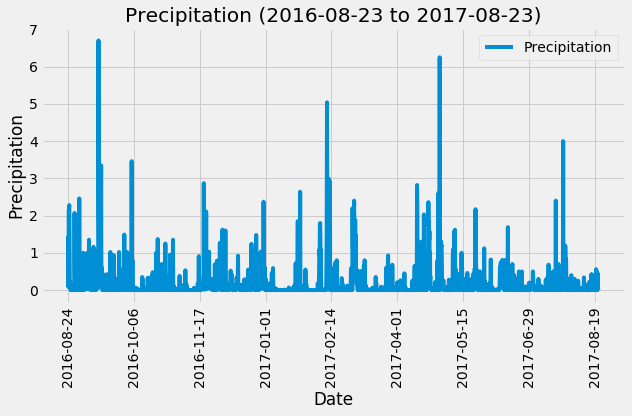

In [255]:
# Use Pandas Plotting with Matplotlib to plot the data
last_12month_data_df.plot(figsize=(9,6))
plt.title("Precipitation ({0} to {1})".format(last_12month_date.date(),latest_date[0]))
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.legend(["Precipitation"])
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [256]:
# Use Pandas to calcualte the summary statistics for the precipitation data
print("The summary statistics for the precipitation data")
last_12month_data_df.describe()

The summary statistics for the precipitation data


,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [257]:
# Design a query to show how many stations are available in this dataset?
print("Design a query to show how many stations are available in this dataset")
station_count = session.query(Measurement).group_by(Measurement.station).count()
print("There are {a} stations.".format(a=station_count))

Design a query to show how many stations are available in this dataset
There are 9 stations.


In [258]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_station= session.query(Measurement.station,func.count(Measurement.station)\
                     ).group_by(Measurement.station\
                    ).order_by(func.count(Measurement.station\
                    ).desc()).all()
print("What are the most active stations?")
print("The most active station: {a}, the counts is: {b} \
    ".format(a=most_active_station[0][0], b=most_active_station[0][1]))

print("\nList the stations and the counts in descending order")
for station in most_active_station:
    print("The station Number: {a}, the counts is: {b} \
    ".format(a=station[0], b=station[1]))

What are the most active stations?
The most active station: USC00519281, the counts is: 2772     

List the stations and the counts in descending order
The station Number: USC00519281, the counts is: 2772     
The station Number: USC00519397, the counts is: 2724     
The station Number: USC00513117, the counts is: 2709     
The station Number: USC00519523, the counts is: 2669     
The station Number: USC00516128, the counts is: 2612     
The station Number: USC00514830, the counts is: 2202     
The station Number: USC00511918, the counts is: 1979     
The station Number: USC00517948, the counts is: 1372     
The station Number: USC00518838, the counts is: 511     


In [270]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
lowest_temperature = session.query(func.min(Measurement.tobs)).\
    filter(Measurement.station == most_active_station[0][0]).all()
print("Using the station id from the previous query, calculate the lowest temperature recorded")
print("The lowest temperature recorded in the station {a} is {b} F\
    ".format(a=most_active_station[0][0], b=lowest_temperature[0][0]))

Using the station id from the previous query, calculate the lowest temperature recorded
The lowest temperature recorded in the station USC00519281 is 54.0 F    


In [271]:
# highest temperature recorded, and average temperature of the most active station?
highest_average_temperature_station =session.query(Measurement.station, \
                    func.max(Measurement.tobs), \
                    func.avg(Measurement.tobs)).\
                    group_by(Measurement.station).\
                    filter(Measurement.station == most_active_station[0][0]).all()
print("The highest temperature recorded, and average temperature of the most active station")
print("The highest temperature recorded in the most active station {a} is {b} F\
    ".format(a=highest_average_temperature_station[0][0],\
             b=highest_average_temperature_station[0][1]))
print("The average temperature recorded in the most active station {a} is {b} F\
    ".format(a=highest_average_temperature_station[0][0],\
             b=round(highest_average_temperature_station[0][2],2)))

The highest temperature recorded, and average temperature of the most active station
The highest temperature recorded in the most active station USC00519281 is 85.0 F    
The average temperature recorded in the most active station USC00519281 is 71.66 F    


In [272]:
# Choose the station with the highest number of temperature observations.
highest_number_temperature_observations =session.query(Measurement.station, \
                    func.count(Measurement.tobs)). \
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).first()

print("Choose the station with the highest number of temperature observations")
print("The station with the highest number of temperature observations is {a}"\
      .format(a=highest_number_temperature_observations[0]))

Choose the station with the highest number of temperature observations
The station with the highest number of temperature observations is USC00519281


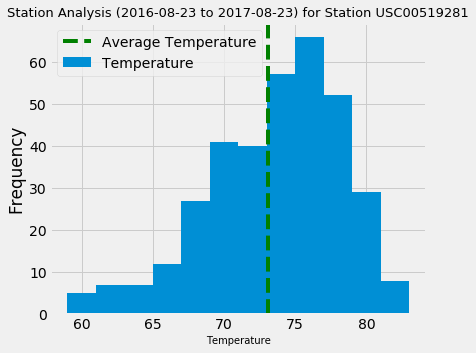

In [273]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_12month_temperature_observation = session.query(Measurement.date, Measurement.tobs)\
                        .order_by(Measurement.date)\
                        .filter(Measurement.date > last_12month_date.date())\
                        .filter(Measurement.station == highest_number_temperature_observations[0])\
                        .all()
last_12month_df= pd.DataFrame(last_12month_temperature_observation)

fig = plt.figure(figsize = (6,5))
ax = fig.gca()
last_12month_df.plot.hist(bins=12, ax = ax,density=False )
plt.axvline(last_12month_df['tobs'].mean(), color='g', linestyle='dashed', label="Average Temperature")
plt.xlabel("Temperature", fontsize=10)
plt.title("Station Analysis ({0} to {1}) for Station {2}".format(last_12month_date.date(),latest_date[0], \
          highest_number_temperature_observations[0]), fontsize=13)
plt.legend([ "Average Temperature", "Temperature"])
plt.show()

## Bonus Challenge Assignment

In [274]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
tour_start_date = '2012-02-28'
tour_end_date = '2012-03-05'
min_ave_max = calc_temps(tour_start_date, tour_end_date)
print("The tour start date:{0}".format(tour_start_date))
print("The tour end date:{0}".format(tour_end_date))
print("The minimum temperatures {a}\nThe average temperatures {b}\nThe maximum temperatures {c}"\
      .format(a= min_ave_max[0][0], b= round(min_ave_max[0][1],2), c= min_ave_max[0][2]))

The tour start date:2012-02-28
The tour end date:2012-03-05
The minimum temperatures 62.0
The average temperatures 69.57
The maximum temperatures 74.0


In [275]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
tour_start_date = datetime.date(2018, 8, 8)
tour_end_date = datetime.date(2018, 8, 15)
twelve_month = datetime.timedelta(days=365)
temp_min_ave_max = (calc_temps((tour_start_date-twelve_month), (tour_end_date-twelve_month)))

print("The tour start date:{0}".format(tour_start_date))
print("The tour end date:{0}".format(tour_end_date))
print("The minimum temperatures {a}\nThe average temperatures {b}\nThe maximum temperatures {c}"\
      .format(a= temp_min_ave_max[0][0], b= round(temp_min_ave_max[0][1],2), c= temp_min_ave_max[0][2]))


The tour start date:2018-08-08
The tour end date:2018-08-15
The minimum temperatures 70.0
The average temperatures 78.55
The maximum temperatures 84.0


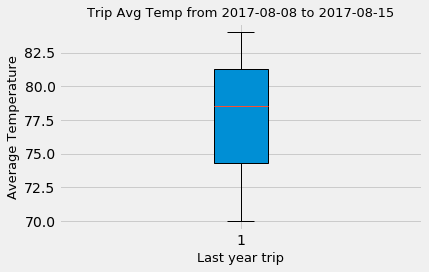

In [276]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots()
x = range(len(temp_min_ave_max))
ax.boxplot(temp_min_ave_max, patch_artist=True)
ax.set_title("Trip Avg Temp from {a} to {b}"\
             .format(a = str(tour_start_date-twelve_month), \
                     b = str(tour_end_date-twelve_month)),\
             fontsize=13)
             
ax.set_ylabel("Average Temperature",fontsize=13)
ax.set_xlabel("Last year trip", fontsize=13)
fig.tight_layout()
plt.show()

In [277]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

total_amount_rainfall = session.query(Measurement.station, \
                        Station.name, Station.latitude,\
                        Station.longitude, Station.elevation,\
                        func.sum(Measurement.prcp))\
                        .group_by(Measurement.station)\
                        .filter(Measurement.date >= (tour_start_date-twelve_month))\
                        .filter(Measurement.date <=(tour_end_date-twelve_month))\
                        .order_by(func.sum(Measurement.prcp).desc())\
                        .filter(Measurement.station == Station.station).all()


print("list the station,name, latitude, longitude, and elevation")
print("---------------------------------------")
for station in total_amount_rainfall:
    print(" Station: {a}\n Name: {b}\n latitude: {c}\
        \n longitude: {d}\n elevation: {e}\n Total amount of rainfall between {g} and {h} is: {f}"\
          .format(a=station[0],b=station[1],c=station[2],\
            d=station[3],e=station[4],f=station[5],\
            g=(tour_start_date-twelve_month),h=(tour_end_date-twelve_month)))
    print("---------------------------------------")

list the station,name, latitude, longitude, and elevation
---------------------------------------
 Station: USC00516128
 Name: MANOA LYON ARBO 785.2, HI US
 latitude: 21.3331        
 longitude: -157.8025
 elevation: 152.4
 Total amount of rainfall between 2017-08-08 and 2017-08-15 is: 1.34
---------------------------------------
 Station: USC00519281
 Name: WAIHEE 837.5, HI US
 latitude: 21.45167        
 longitude: -157.84888999999998
 elevation: 32.9
 Total amount of rainfall between 2017-08-08 and 2017-08-15 is: 0.32
---------------------------------------
 Station: USC00519523
 Name: WAIMANALO EXPERIMENTAL FARM, HI US
 latitude: 21.33556        
 longitude: -157.71139
 elevation: 19.5
 Total amount of rainfall between 2017-08-08 and 2017-08-15 is: 0.14
---------------------------------------
 Station: USC00514830
 Name: KUALOA RANCH HEADQUARTERS 886.9, HI US
 latitude: 21.5213        
 longitude: -157.8374
 elevation: 7.0
 Total amount of rainfall between 2017-08-08 and 2017-08-15

In [229]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

tour_date = "01-01"
daily_min_avg_max = daily_normals(tour_date)
print("The tour date:{0}".format(tour_date))
print("The minimum temperatures {a}\nThe average temperatures {b}\nThe maximum temperatures {c}"\
      .format(a= daily_min_avg_max[0][0], b= round(daily_min_avg_max[0][1],2), c= daily_min_avg_max[0][2]))

The tour date:01-01
The minimum temperatures 62.0
The average temperatures 69.15
The maximum temperatures 77.0


In [230]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []

# Set the start and end date of the trip

tour_start_date = datetime.date(2018, 8, 8)
tour_end_date = datetime.date(2018, 8, 15)

twelve_month = datetime.timedelta(days=365)

last_year_tour_start_date = tour_start_date -twelve_month
last_year_tour_end_date = tour_end_date -twelve_month

# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings

trip_dates = []

# Loop through the list of %m-%d strings and calculate the normals for each date
for days in range((last_year_tour_end_date-last_year_tour_start_date).days+1):
    normals.append(daily_normals((last_year_tour_start_date +  datetime.timedelta(days=days)).strftime('%m-%d'))[0])
    trip_dates.append(last_year_tour_start_date +  datetime.timedelta(days=days))
normals

[(68.0, 76.5576923076923, 83.0),
 (69.0, 75.98039215686275, 81.0),
 (65.0, 76.42, 83.0),
 (67.0, 75.98113207547169, 82.0),
 (67.0, 76.52727272727273, 83.0),
 (71.0, 76.98245614035088, 84.0),
 (71.0, 76.77777777777777, 82.0),
 (69.0, 76.47169811320755, 83.0)]

In [231]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns=['min', 'avg', 'max'])

normals_df["date"] = trip_dates
normals_df.set_index('date', inplace=True)
normals_df.head(8)

,min,avg,max
date,,,
2017-08-08,68.0,76.557692,83.0
2017-08-09,69.0,75.980392,81.0
2017-08-10,65.0,76.420000,83.0
2017-08-11,67.0,75.981132,82.0
2017-08-12,67.0,76.527273,83.0
2017-08-13,71.0,76.982456,84.0
2017-08-14,71.0,76.777778,82.0
2017-08-15,69.0,76.471698,83.0


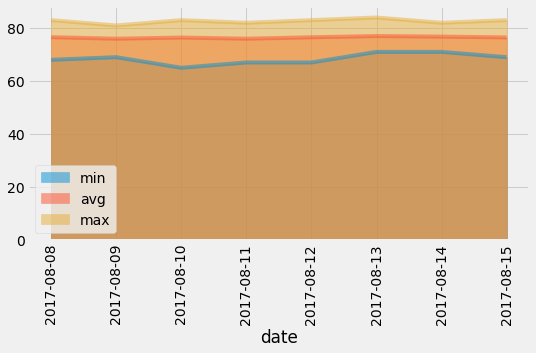

In [232]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind='area', stacked=False, figsize=(8,4))
plt.xticks(rotation=90)
plt.legend(loc='best')
plt.show(block=True);

### Temperature Analysis I

In [312]:
# Hawaii is reputed to enjoy mild weather all year. 
#Is there a meaningful difference between the temperature in, for example, June and December?
# Identify the average temperature in June 
# at all stations across all available years in the dataset. Do the same for December temperature.

avg_temp_June = session.query(func.avg(Measurement.tobs)).filter(func.strftime("%m", Measurement.date) == '06').all()
avg_temp_Dec = session.query(func.avg(Measurement.tobs)).filter(func.strftime("%m", Measurement.date) == '12').all()
print("The average temperature is: {0:.2f} in June. {1:.2f} in December. "\
      .format(avg_temp_June[0][0], avg_temp_Dec[0][0]))


The average temperature is: 74.94 in June. 71.04 in December. 


In [313]:
# Use the t-test to determine whether the difference in the means, 
#if any, is statistically significant. Will you use a paired t-test, 
#or an unpaired t-test? Why?

#obtain weather data of the month June
avg_temp_June = session.query(Measurement.tobs).filter(func.strftime("%m", Measurement.date) == '06').all()

#obtain weather data of the month December
avg_temp_Dec = session.query(Measurement.tobs).filter(func.strftime("%m", Measurement.date) == '12').all()

#convert data to list  
avg_temp_June_list = list(np.ravel(avg_temp_June))
avg_temp_Dec_list = list(np.ravel(avg_temp_Dec))

In [309]:
#Test whether or not the lists June and  December come from populations with equal variances
small_pvalue = stats.levene(avg_temp_June_list,avg_temp_Dec_list)
if small_pvalue.pvalue < 0.05:
    print("The small p-value is: {0} p-value<0.05. the populations \
do not have equal variances".format(small_pvalue.pvalue))
else:
    print("The small p-value is: {0} p-value>=0.05. the populations \
have equal variances".format(small_pvalue.pvalue))
#The small p-value<0.05 suggests that the populations do not have equal variances.

The small p-value is: 0.0007094853311953783 p-value<0.05. the populations do not have equal variances


In [311]:
# I use the unpaired t-test procedure that compares the means of two independent data, 
# because weather data from June and December is independent. 

#perform two sample t-test
if small_pvalue.pvalue < 0.05:
    # population variances is not equal
    pvalue = stats.ttest_ind(avg_temp_June_list, avg_temp_Dec_list, equal_var=False)
else:
    # population variances is equal
    pvalue = stats.ttest_ind(avg_temp_June_list, avg_temp_Dec_list, equal_var=True)
    
if pvalue.pvalue < 0.05:    
    print("The p-value is: {0} p-value<0.05. two data samples have \
significant different means.".format(small_pvalue.pvalue))
else:
    print("The p-value is: {0} p-value<0.05. two data samples have \
similar means.".format(small_pvalue.pvalue))

    
# The p-value<0.05 suggests that the populations two data samples have significant different means.  

The p-value is: 0.0007094853311953783 p-value<0.05. two data samples have significant different means.


In [236]:
#* The starter notebook contains a function called `calc_temps` that will 
#accept a start date and end date in the format `%Y-%m-%d`. 
#The function will return the minimum, average, and maximum temperatures for that range of dates.
def calc_temps(start_date, end_date):
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(\
            func.strftime("%Y-%m-%d",Measurement.date) >=func.strftime("%Y-%m-%d", start_date) ).filter(\
            func.strftime("%Y-%m-%d",Measurement.date) <=func.strftime("%Y-%m-%d", end_date) ).all()
calc_temps('2017-01-01','2018-01-01')

[(58.0, 74.14387974230493, 87.0)]

In [237]:
#* Plot the min, avg, and max temperature from your previous query as a bar chart.
#* Use the average temperature as the bar height.
#* Use the peak-to-peak (TMAX-TMIN) value as the y error bar (YERR).
mytrip = calc_temps('2017-01-01','2018-01-01')

mytrip_df = pd.DataFrame(mytrip, columns=['min', 'avg', 'max'])
mytrip_df

,min,avg,max
0,58.0,74.14388,87.0


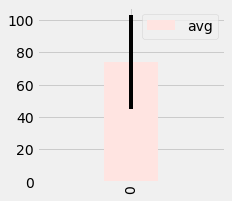

In [238]:
error = mytrip_df['max'].sub(mytrip_df['min'])
mytrip_df.plot.bar(y='avg',yerr=error, color='mistyrose', width = 0.2, figsize=(3,3))

In [239]:
#Calculate the rainfall per weather station using the previous year's matching dates.
def calc_prcp_by_station(start_date, end_date):

    return session.query(Measurement.station, func.sum(Measurement.prcp)).filter(\
            func.strftime("%Y-%m-%d",Measurement.date) >=func.strftime("%Y-%m-%d", start_date) ).filter(\
            func.strftime("%Y-%m-%d",Measurement.date) <=func.strftime("%Y-%m-%d", end_date) )\
            .group_by(Measurement.station).all()

calc_prcp_by_station('2017-01-01','2018-01-01')

[('USC00513117', 34.62000000000001),
 ('USC00514830', 21.80000000000002),
 ('USC00516128', 68.78000000000003),
 ('USC00517948', 3.39),
 ('USC00519281', 43.66000000000002),
 ('USC00519397', 10.659999999999993),
 ('USC00519523', 27.319999999999993)]

In [240]:
#* Calculate the daily normals. Normals are the averages for the min, avg, and max temperatures.
#* You are provided with a function called `daily_normals` 
#that will calculate the daily normals for a specific date. 
#This date string will be in the format `%m-%d`. 
#Be sure to use all historic TOBS that match that date string.
def daily_normals(date):
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return  session.query(*sel).filter(func.strftime("%m-%d",Measurement.date) == date).all()

daily_normals('02-01')

[(56.0, 68.14035087719299, 78.0)]

In [241]:
#* Create a list of dates for your trip in the format `%m-%d`. 
#Use the `daily_normals` function to calculate the normals 
#for each date string and append the results to a list.
end_date = datetime.datetime.strptime("01-15", '%m-%d')
start_date = datetime.datetime.strptime("01-01", '%m-%d')
tour_days = end_date - start_date
result = []
date = []
for day in range(tour_days.days + 1):
    current_date = start_date + datetime.timedelta(days=day)
    date.append(current_date.strftime("%m-%d"))
    result.append(daily_normals((current_date).strftime("%m-%d"))[0])
    
mytrip_df = pd.DataFrame(result, columns=['min', 'avg', 'max'])
mytrip_df['date'] = date
#Load the list of daily normals into a Pandas DataFrame and set the index equal to the date.
mytrip_df.set_index('date', inplace=True)
mytrip_df.head()
mytrip_df

,min,avg,max
date,,,
01-01,62.0,69.153846,77.0
01-02,60.0,69.396226,77.0
01-03,62.0,68.909091,77.0
01-04,58.0,70.000000,76.0
01-05,56.0,67.964286,76.0
01-06,61.0,68.964912,76.0
01-07,57.0,68.543860,76.0
01-08,57.0,67.160714,75.0
01-09,58.0,67.929825,78.0


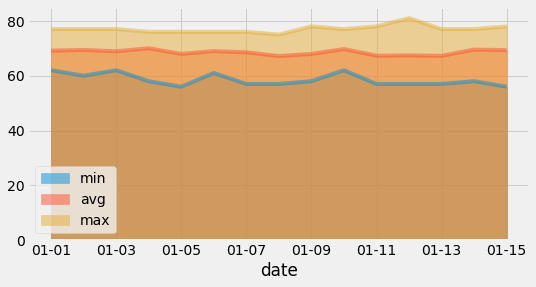

In [242]:
#* Use Pandas to plot an area plot (`stacked=False`) for the daily normals.
mytrip_df.plot(kind='area', stacked=False, figsize=(8,4))
#plt.xticks(rotation=90)
plt.legend(loc='best')
plt.show(block=True);